<a href="https://colab.research.google.com/github/ronylitv14/RaccoonDetector/blob/main/RCNN_raccoons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab.patches import cv2_imshow
import cv2

import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import tensorflow as tf

import os
from pathlib import Path
import tarfile


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [71]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.applications import resnet50
from tensorflow.keras.models import load_model

PATH_TO_MODEL = "/content/drive/MyDrive/raccon_folder_model/raccon_model_final.keras" # @param {type:"string"}
HAS_TRAINED_MODEL = False # @param {type:"boolean"}

if HAS_TRAINED_MODEL and PATH_TO_MODEL:
  model = load_model(PATH_TO_MODEL)
else:
  print("You have to specify RCNN model for raccoon dataset!!")

You have to specify RCNN model for raccoon dataset!!


In [4]:
if not Path('raccoon_dataset').exists():
  !git clone https://github.com/datitran/raccoon_dataset


Cloning into 'raccoon_dataset'...
remote: Enumerating objects: 652, done.
remote: Counting objects: 100% (652/652), done.
remote: Compressing objects: 100% (235/235), done.
remote: Total 652 (delta 416), reused 649 (delta 415), pack-reused 0
Receiving objects: 100% (652/652), 48.01 MiB | 13.38 MiB/s, done.
Resolving deltas: 100% (416/416), done.


# Training model

In [5]:
cur_dir = os.getcwd()

dir_to_images = os.path.join(cur_dir, 'raccoon_dataset', 'images')
dir_to_annotations = os.path.join(cur_dir, 'raccoon_dataset', 'annotations')

In [6]:
from pathlib import Path
import cv2
from bs4 import BeautifulSoup

def get_all_images(path_to_img):
    """
    Function to read all images from a given directory.

    :param path_to_img: Path to the directory where images are stored
    :return: List of images as OpenCV arrays
    """
    dir_elems = Path(path_to_img)
    all_images = []

    for img in sorted(dir_elems.iterdir()):
        img_arr = cv2.imread(os.path.join(path_to_img, img))
        all_images.append(img_arr)

    return all_images

def get_annotations(path_to_annot):
    """
    Function to read annotations (bounding boxes) for images from XML files.

    :param path_to_annot: Path to the directory where annotations (XML files) are stored
    :return: List of annotations for each image
    """
    dir_elems = Path(path_to_annot)

    all_annotations = []
    for annot in sorted(dir_elems.iterdir()):
        bnd_arr = []
        with open(os.path.join(path_to_annot, annot), 'r') as xml_file:
            soup = BeautifulSoup(xml_file, 'lxml')

            bndboxes = soup.find_all('bndbox')

            for single_bndbox in bndboxes:
                bnd_crd = single_bndbox.text.split('\n')
                bnd_crd = bnd_crd[1:5]
                bnd_crd = [int(coord) for coord in bnd_crd]

                bnd_arr.append(bnd_crd)
            all_annotations.append(bnd_arr)

    return all_annotations

In [7]:
images = get_all_images(dir_to_images)
annotations = get_annotations(dir_to_annotations)

assert len(images) == len(annotations)

In [8]:
def visualize_img_with_gt_box(img, annotation, mode='default'):
    """
    Visualization of an image with annotations (bounding boxes).

    :param img: Image in a format compatible with OpenCV
    :param annotation: List of annotations, where each annotation is represented as [x_min, y_min, x_max, y_max]
    :param mode: Display mode. 'default' for green rectangles, any other mode for random colors
    """

    clone = img.copy()
    for annot in annotation:
        if mode == 'default':
            start_point = (annot[0], annot[1])  # Top-left corner
            end_point = (annot[2], annot[3])  # Bottom-right corner

            rect = cv2.rectangle(clone, start_point, end_point, color=[0, 255, 0])
        else:
            # In other modes, use random colors
            start_point = (annot[0], annot[1])
            end_point = (annot[2] + annot[0], annot[3] + annot[1])
            color = [np.random.randint(0, 256) for _ in range(3)]

            rect = cv2.rectangle(clone, start_point, end_point, color=color)
    cv2_imshow(clone)


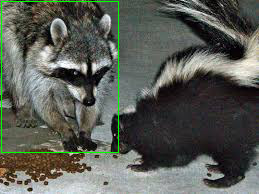

In [9]:
rand_ind = np.random.randint(0, 200)
visualize_img_with_gt_box(images[rand_ind], annotations[rand_ind])

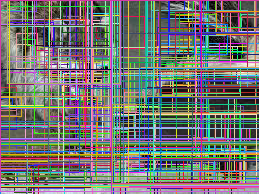

In [10]:
# Testing Selective Search algorithm

ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(images[rand_ind])
ss.switchToSelectiveSearchFast()

rects = ss.process()

visualize_img_with_gt_box(images[rand_ind], rects, mode='selective_search')

In [11]:
def compute_iou(boxA, boxB):
    """
    Calculate Intersection over Union (IoU) for two rectangles.

    :param boxA: Coordinates of the first rectangle in the format [x_min, y_min, x_max, y_max]
    :param boxB: Coordinates of the second rectangle in the same format
    :return: IoU value between the two rectangles
    """
    # Determine the coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # Calculate the area of the intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # Calculate the area of each rectangle
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # Calculate IoU
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou


def get_selective_search_rects(img, mode="default"):
    """
    Use selective search to detect potential objects in an image.

    :param img: Image in a format compatible with OpenCV
    :param mode: Selective search mode, "default" or "fast"
    :return: List of rectangles detected by selective search
    """
    # Initialize selective search
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(img)

    if mode == "default":
        ss.switchToSelectiveSearchQuality()
    elif mode == "fast":
        ss.switchToSelectiveSearchFast()

    # Process the image to find rectangles
    rects = ss.process()
    return rects


In [69]:
MAX_POSITIVE_ROIS = 20
MAX_NEGATIVE_ROIS = 8

POSITIVE_ROI_LEFTBORDER = 0.8
POSITIVE_ROI_RIGHTBOARDER = 0.9
NEGATIVE_ROI_BOARDER = 0.1

def get_valid_rois(ds_images, ds_annot):
    """
    Determine valid Regions of Interest (ROIs) from a set of images and annotations.

    :param ds_images: List of images
    :param ds_annot: List of annotations for these images
    :return: Two lists - positive_rois and negative_rois, which contain positive and negative ROIs respectively
    """
    positive_rois = []
    negative_rois = []

    for (img, annot) in zip(ds_images, ds_annot):
        # Calculate the threshold area as a percentage of the image area
        area_img_per = img.shape[0] * img.shape[1] / 100

        pos_counter = 0  # Counter for positive ROIs
        neg_counter = 0  # Counter for negative ROIs

        rects = get_selective_search_rects(img)  # Get ROIs using selective search
        for x, y, w, h in rects:
            # Skip very small regions
            if (w * h) < area_img_per * 5:
                continue

            first_box = (x, y, x + w, y + h)  # Form the current ROI

            for gt_box in annot:
                iou = compute_iou(first_box, gt_box)  # Calculate IoU with annotation

                # Add positive ROIs based on conditions
                if iou > POSITIVE_ROI_LEFTBORDER \
                   and iou <= POSITIVE_ROI_RIGHTBOARDER \
                   and pos_counter < MAX_POSITIVE_ROIS:
                    roi_image = img[y:y+h, x:x+w]
                    pos_counter += 1
                    if roi_image is not None:
                        positive_rois.append(roi_image)

                # Add negative ROIs based on conditions
                elif iou < NEGATIVE_ROI_BOARDER \
                and neg_counter < MAX_NEGATIVE_ROIS:

                    roi_image = img[y:y+h, x:x+w]
                    neg_counter += 1
                    if roi_image is not None:
                        negative_rois.append(roi_image)

    return positive_rois, negative_rois


In [72]:
if not HAS_TRAINED_MODEL:
  positive_rois, negative_rois = get_valid_rois(images, annotations)

In [73]:
if not Path('dataset').exists():
  os.mkdir(os.path.join(cur_dir, 'dataset'))

  os.mkdir(os.path.join(cur_dir, 'dataset', 'no_raccoons'))
  os.mkdir(os.path.join(cur_dir, 'dataset', 'raccoons'))

dir_raccoons = os.path.join(cur_dir, 'dataset', 'raccoons')
dir_no_raccoons = os.path.join(cur_dir, 'dataset', 'no_raccoons')

def prepare_positiv_roi(rois):

  os.chdir(dir_raccoons)

  for ind, short_img in enumerate(rois):
    cv2.imwrite(f'raccoon_{ind}.jpg', short_img)

  print('Successfully uploaded all positive ROI`s for raccoons')

def prepare_negative_roi(rois):

  os.chdir(dir_no_raccoons)

  for ind, short_img in enumerate(rois):
    cv2.imwrite(f'no_raccoon_{ind}.jpg', short_img)

  print('Successfully uploaded all negative ROI`s for raccoons')

if not HAS_TRAINED_MODEL:
  prepare_positiv_roi(positive_rois)
  prepare_negative_roi(negative_rois)

Successfully uploaded all positive ROI`s for raccoons
Successfully uploaded all negative ROI`s for raccoons


In [24]:
dataset_dir = os.path.join(cur_dir, 'dataset')

IMG_HEIGHT = 224
IMG_WIDTH = 224

BATCH_SIZE = 128

In [74]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.3,
  label_mode='categorical',
  subset="training",
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE,
  shuffle=False)

val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.3,
  label_mode='categorical',
  subset="validation",
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE,
  shuffle=False)

train_ds = train_ds.shuffle(800, reshuffle_each_iteration=True)

Found 3277 files belonging to 2 classes.
Using 2294 files for training.
Found 3277 files belonging to 2 classes.
Using 983 files for validation.


In [75]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Flatten, Dense, MaxPooling2D
from keras.applications import EfficientNetB3


efficientnetb3_head = EfficientNetB3(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)


for layer in efficientnetb3_head.layers:
    if 'top_conv' in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False


43941136/43941136 [==============================] - 3s 0us/step


In [ ]:
efficientnetb3_head.summary()

Model: "efficientnetb3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['normalization[0

In [79]:
model = Sequential([
    efficientnetb3_head,
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(2, activation='softmax')
])

model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.RMSprop(),
    metrics=['accuracy']
)

In [80]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 7, 7, 1536)        10783535  
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 75264)             0         
                                                                 
 dense_3 (Dense)             (None, 1024)              77071360  
                                                                 
 dense_4 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_5 (Dense)             (None, 2)                 2050      
                                                                 
Total params: 88906545 (339.15 MB)
Trainable params: 78712834 (300.27 MB)
Non-trainable params: 10193711 (38.89 MB)
____

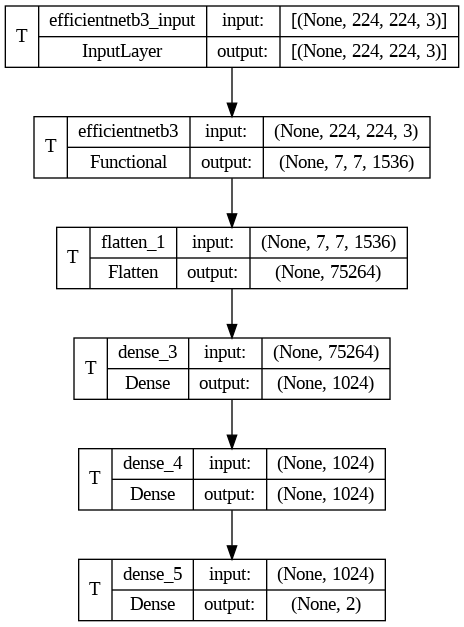

In [81]:
from tensorflow.keras.utils import plot_model

plot_model(
    model,
    show_shapes=True,
    show_trainable=True
)

In [82]:
from tensorflow.keras.callbacks import Callback

class CustomEarlyStopping(Callback):
    def __init__(self, train_acc_threshold=0.9, val_acc_threshold=0.9):
        super(CustomEarlyStopping, self).__init__()
        self.train_acc_threshold = train_acc_threshold
        self.val_acc_threshold = val_acc_threshold

    def on_epoch_end(self, epoch, logs=None):
        train_acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')
        if train_acc is not None and val_acc is not None:
            if train_acc > self.train_acc_threshold and val_acc > self.val_acc_threshold:
                self.model.stop_training = True
                print(f"\nStopping Training: Train Accuracy: {train_acc}, Validation Accuracy: {val_acc}")


In [83]:
early_stopping_callback = CustomEarlyStopping(train_acc_threshold=0.94, val_acc_threshold=0.9)

model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[early_stopping_callback]
)

Epoch 1/10
18/18 [==============================] - 38s 1s/step - loss: 27.7357 - accuracy: 0.8060 - val_loss: 2.0557 - val_accuracy: 0.8515
Epoch 2/10
18/18 [==============================] - ETA: 0s - loss: 0.1964 - accuracy: 0.9634
Stopping Training: Train Accuracy: 0.9633827209472656, Validation Accuracy: 0.9684638977050781
18/18 [==============================] - 16s 752ms/step - loss: 0.1964 - accuracy: 0.9634 - val_loss: 1.4909 - val_accuracy: 0.9685


In [84]:
model.evaluate(val_ds)

8/8 [==============================] - 4s 404ms/step - loss: 1.4909 - accuracy: 0.9685


[1.4909145832061768, 0.9684638977050781]

In [85]:
def prepare_img(img):
  img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
  return img

def prepare_img_resnet(img):
  img = cv2.resize(img, (224, 224))
  img = resnet50.preprocess_input(img)
  return img

def get_rois_of_image(img, rects, prepare_img_func=prepare_img):

  clone_img = img.copy()

  clone_img_height, clone_img_width, _ = clone_img.shape
  img_area_per = (clone_img_height * clone_img_width) / 100

  proposals = []
  boxes = []

  for x, y, w, h in rects:
    if img_area_per * 10 <= (w * h) <= img_area_per * 70:

      if y == 0:
        y += 10

      if x == 0:
        x += 10

      if w == clone_img_width:
        w -= 10

      if h == clone_img_height:
        h -= 10

      roi = clone_img[y:y + h, x:x + w]
      roi = prepare_img_func(roi)

      proposals.append(roi)
      boxes.append((x, y, x + w, h + y))

  return proposals, boxes

def non_max_suppression_slow(boxes, overlapThresh):
  pick = []

  if len(boxes) == 0:
	  return []

  x1 = boxes[:,0]
  y1 = boxes[:,1]
  x2 = boxes[:,2]
  y2 = boxes[:,3]

  area = (x2 - x1 + 1) * (y2 - y1 + 1)
  idxs = np.argsort(y2)

  while len(idxs) > 0:
    last = len(idxs) - 1
    i = idxs[last]
    pick.append(i)
    suppress = [last]

    for pos in range(0, last):
        j = idxs[pos]

        xx1 = max(x1[i], x1[j])
        yy1 = max(y1[i], y1[j])
        xx2 = min(x2[i], x2[j])
        yy2 = min(y2[i], y2[j])

        w = max(0, xx2 - xx1 + 1)
        h = max(0, yy2 - yy1 + 1)
        overlap = float(w * h) / area[j]

        if overlap > overlapThresh:
          suppress.append(pos)

    idxs = np.delete(idxs, suppress)
  return boxes[pick]



def get_id_for_proba(proba):
  idxs = []
  max_proba = max(proba[:, 1])
  if max_proba >= 0.99:
    max_proba = 1.0

  for ind, prob_exmpl in enumerate(proba):
    if prob_exmpl[1] >= max_proba - 0.01:
      idxs.append(ind)

  return idxs

def NMS(boxes, overlap_thresh = 0.3):

    if len(boxes) == 0:
        return []
    x1 = boxes[:, 0]  # x coordinate of the top-left corner
    y1 = boxes[:, 1]  # y coordinate of the top-left corner
    x2 = boxes[:, 2]  # x coordinate of the bottom-right corner
    y2 = boxes[:, 3]  # y coordinate of the bottom-right corner

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    indices = np.arange(len(x1))
    for i,box in enumerate(boxes):
        temp_indices = indices[indices!=i]
        xx1 = np.maximum(box[0], boxes[temp_indices,0])
        yy1 = np.maximum(box[1], boxes[temp_indices,1])
        xx2 = np.minimum(box[2], boxes[temp_indices,2])
        yy2 = np.minimum(box[3], boxes[temp_indices,3])
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        overlap = (w * h) / areas[temp_indices]
        if np.any(overlap) > overlap_thresh:
            indices = indices[indices != i]
    return boxes[indices].astype(int)

In [21]:
racconn_img = get_all_images(dir_to_images)

In [59]:
def pipeline_for_creating_preds(img, annot=None, mode="fast", nn_model=model, prepare_img_func=prepare_img):
  random_img = img.copy()

  rects = get_selective_search_rects(random_img, mode=mode)
  proposals, boxes = get_rois_of_image(random_img, rects, prepare_img_func=prepare_img_func)

  proposals = np.asarray(proposals)
  boxes = np.asarray(boxes)

  proba = nn_model.predict(proposals)
  idxs = get_id_for_proba(proba)

  new_boxes = boxes[idxs]
  new_proposals = proposals[idxs]
  new_proba = proba[idxs]

  return new_boxes, new_proposals, new_proba

def visualize_img_with_predictions(boxes, proba, img):
  clone = img.copy()

  for (box, prob) in zip(boxes, proba):

    (startX, startY, endX, endY) = box
    cv2.rectangle(clone, (startX, startY), (endX, endY),
      (0, 255, 0), 2)
    y = startY - 10 if startY - 10 > 10 else startY + 10
    text= f"Raccoon: {prob[1] * 100:.2f}%"
    cv2.putText(clone, text, (startX, y),
      cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 0, 0), 2)

  cv2_imshow(clone)

def visualize_final_image(
    random_image,
    nms_func=non_max_suppression_slow,
    thickness=3,
    overlap_thresh=0.3
):
  good_box = nms_func(boxes, overlap_thresh)
  clone = random_image.copy()

  for x, y, w, h in good_box:

    cv2.rectangle(clone, (x, y), (w, h), color=[0, 255, 0], thickness=thickness)

  cv2_imshow(clone)

In [94]:
rand_ind = np.random.randint(0, 200)

random_img = racconn_img[rand_ind]
random_annot = annotations[rand_ind]

boxes, proposals, proba = pipeline_for_creating_preds(random_img, random_annot)

6/6 [==============================] - 2s 469ms/step


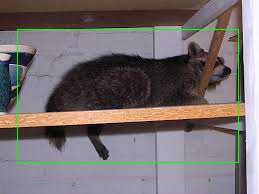

In [95]:
visualize_img_with_gt_box(random_img, random_annot)

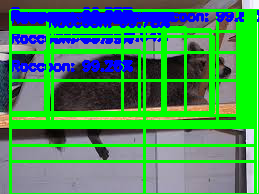

In [96]:
visualize_img_with_predictions(boxes, proba, random_img)

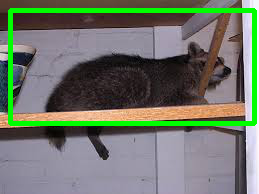

In [97]:
visualize_final_image(random_image=random_img, nms_func=NMS)

In [99]:
model.save("/content/drive/MyDrive/TFModels/raccoons_model_effnetb3.keras")

# Testing model functionality

In [86]:
import io
from PIL import Image
from google.colab import files

uploaded = files.upload()

item_dict = uploaded.popitem()[1]

img = io.BytesIO(item_dict)
img = Image.open(img)
img = np.array(img)

Saving asd.jpeg to asd.jpeg


In [87]:
boxes, props, proba = pipeline_for_creating_preds(
    img,
    mode="fast",
    nn_model=model,
    prepare_img_func=prepare_img
)

2/2 [==============================] - 3s 137ms/step


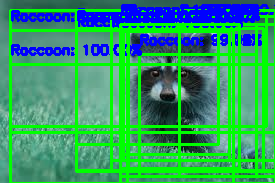

In [88]:
visualize_img_with_predictions(boxes=boxes, img=img, proba=proba)

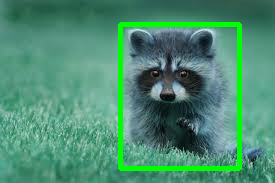

In [89]:
visualize_final_image(img, NMS)

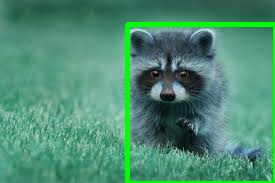

In [90]:
visualize_final_image(img, non_max_suppression_slow)